In [1]:
#!git clone https://github.com/darioka/impactdeal-2022.git
#%cd impactdeal-2022
#!pip install -r requirements.txt
#!pip install .

# Ensemble Models

It is now time to take a look at more advanced techniques for machine learning. In this notebook we will introduce the concept of bootstrap and ensemble models.

## Table of Contents

1. [The Bootstrap method](#The-Boostrap-method)
2. [Model BAGGing](#Model-BAGGing)
3. [Random Forests](#Random-Forests)
4. [Conclusions](#Conclusions)

## The Boostrap method

In a previous notebook we saw how to evaluate the performance of a model on a test dataset. We said that the accuracy computed in this way is an estimation of the true generalization performance of the model. But how confident can we be about this estimation? If we say for example that our model has 80.23% accuracy on a particular test set, if we repeat the same measure on new test data, it's impossible we will recover the exact same number. It will be close, of course, but how close? We need a statistical measure of our uncertainty, i.e. we need **confidence intervals**.

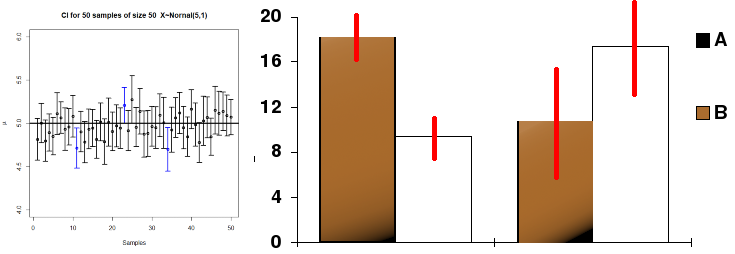

<p style=font-size:10px;>From Wikipedia</p>

**Bootstrapping** allow us to assign confidence intervals to any measure repeating the same measurement on different "versions" of the same dataset, obtained via **random sampling with replacement**.

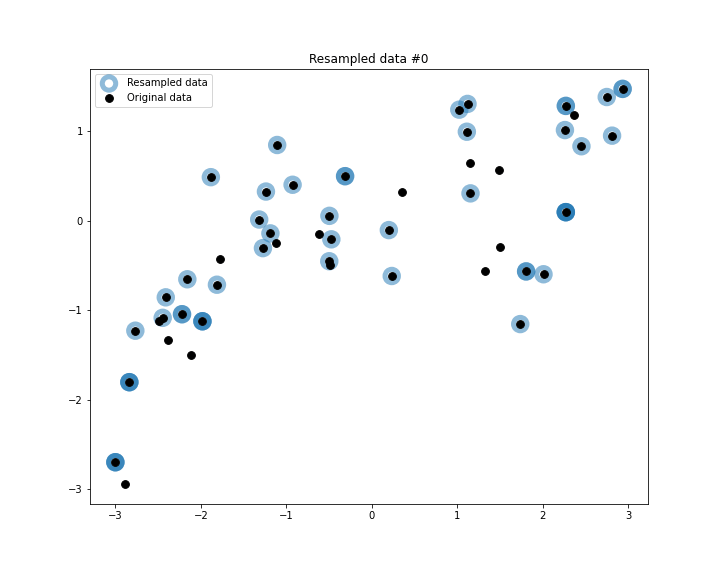

There are many variations of the bootstrap method (take a look a [this blog post](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html#method-3--bootstrapping-the-test-set-predictions) for a review). Here we will make an example with arguably the most simple one.

Let's say we want to **add confidence intervals to the recall of a decision tree trained on the adult dataset**. We will go through the following steps:
1. Split in train and test sets,
2. Fit the model on the train set,
3. For a number of iterations $N$:
    1. Resample the test set with replacement,
    2. Compute recall on the resampled test set.
4. Observe the distribution of the $N$ recall measurement.

In [2]:
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder


X, y = fetch_openml(data_id=1590, return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

numerical_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_cols = ["workclass", "occupation", "sex", "race", "marital-status", "relationship"]

oe = OrdinalEncoder()

cat_X_train = pd.DataFrame(
    oe.fit_transform(X_train[categorical_cols].astype(str)),
    columns=categorical_cols, index=X_train.index
)
cat_X_test = pd.DataFrame(
    oe.transform(X_test[categorical_cols].astype(str)),
    columns=categorical_cols, index=X_test.index
)

preprocessed_X_train = pd.concat([X_train[numerical_cols], cat_X_train], axis=1)
preprocessed_X_test = pd.concat([X_test[numerical_cols], cat_X_test], axis=1)

In [3]:
X.dtypes

age                float64
workclass         category
fnlwgt             float64
education         category
education-num      float64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
dtype: object

In [4]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(preprocessed_X_train, y_train)

DecisionTreeClassifier()

In [5]:
import numpy as np
from tqdm import tqdm

from sklearn.metrics import recall_score


rng = np.random.RandomState(42)
iterations = 200
recalls = []
for n in tqdm(range(iterations)):
    idx = rng.choice(        # choose randomly
        X_test.index,        # from the index of the dataframe
        size=len(X_test),    # an array with the same length
        replace=True         # with replacement
    )
    recalls.append(
        recall_score(
            y_test.loc[idx],
            model.predict(preprocessed_X_test.loc[idx]),
            pos_label=">50K"
        )
    )

recalls = pd.Series(recalls)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.23it/s]


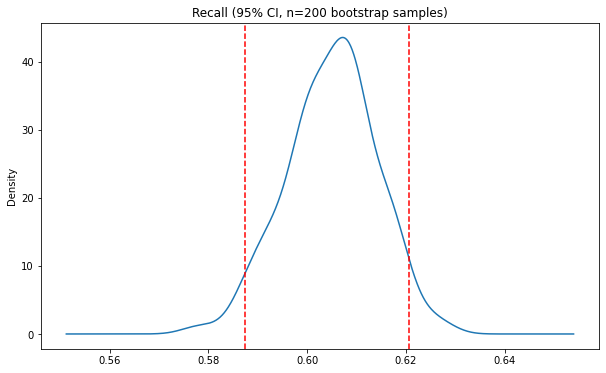

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
recalls.plot.kde()
ci = 0.95
ax.axvline(
    recalls.quantile((1 - ci)/2),  # 2.5% percentile
    color="r", linestyle="--")
ax.axvline(
    recalls.quantile(1 - (1 - ci)/2),
    color="r", linestyle="--")     # 97.5% percentile
plt.title(f"Recall (95% CI, n={iterations} bootstrap samples)")
plt.show()

## Model BAGGing

We introduce the bootstrap as a way to build confidence intervals around a measurement, for example to make a more statistically robust measurement of the performance of a model.

Now we are going to see a completely different way of exploting the same method, that uses resampling to build more accurate models. This technique is called **Bootstrap AGGregating (bagging)** and is at the core of some of the most widely used algorithms in machine learning.

This algorithm works as follows:
* **Training**
    1. Split in train and test sets,
    2. For each iteration $n\in N$:
        1. Resample the training set with replacement (bootstrap)
        2. Train a model on the resampled dataset

* **Predicting**
    1. Predict with all the $N$ models
    2. Average predictions (regression) or voting (classification)

In practice this is not *a* model, but an **ensemble** of models, whose single predictions are aggregated to give the final output. This technique can be applied to any kind of models, but it is particularly useful for models that tend to overfit, like decision trees.

In [7]:
N = 100
bagging_models = []

for n in tqdm(range(N)):
    
    idx = rng.choice(               # choose randomly
        preprocessed_X_train.index, # from the index of the dataframe
        size=len(X_test),           # an array with the same length
        replace=True                # with replacement
    )
    
    model = DecisionTreeClassifier()
    model.fit(preprocessed_X_train.loc[idx], y_train.loc[idx])

    bagging_models.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.28it/s]


In [19]:
y_pred_bagging = pd.DataFrame([m.predict(preprocessed_X_test) for m in bagging_models]).transpose()
y_pred_bagging.index = y_test.index

# one row per test sample
# one column per model prediction
y_pred_bagging.shape

(14653, 100)

In [20]:
# voting
y_pred = y_pred_bagging.apply(
    lambda x: x.value_counts().index[0], # outputs the value with the highest number of occurrences
    axis=1                               # for each row (i.e. apply the function over the columns)
)

              precision    recall  f1-score   support

        >50K       0.75      0.62      0.68      3506
       <=50K       0.89      0.94      0.91     11147

    accuracy                           0.86     14653
   macro avg       0.82      0.78      0.79     14653
weighted avg       0.85      0.86      0.85     14653



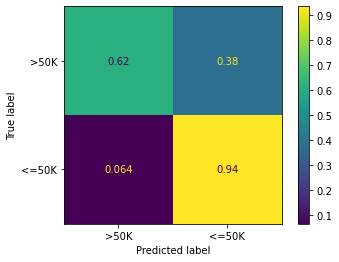

In [21]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[">50K", "<=50K"], normalize="true")

print(classification_report(y_test, y_pred, labels=[">50K", "<=50K"]))

Good! We have built a bagging decision tree classifier from scratch!

We can make a few observations:
* **Performance**: the performances of the bagged classifier are better than the performances of every single model within the ensemble (more on this in the next quiz!). If you remember, we a single fully grown decision tree we overfitted. We managed to obtain a similar accuracy only "cheating" and using the test set to find the best `max_depth`. Here there was no cheating and we obtained a good accuracy without tuning the model.
* **Resources**: the time needed for a bagged classifier with $N$ decision trees is $N$ times the time for a single one. This is important for the training phase, but even more relevant for prediction. Additionally, the model is "heavier", as we have to keep in memory multiple decision trees.
* **Interpretation**: a bagged decision tree is no longer a tree. We lost the simplicity of the underlying model and we cannot interpret anymore the model as a chain of rules.

In real life, of course, we don't have to reimplement bagging each time we want to use it: `scikit-learn` provides a [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) and a [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) for regression and classification respectively.


## Random Forests

With bagging we saw that the collective knowledge of several independents models typically exceeds the one of the single participants. If the models where really independent, then one could even show this is true in general. However, bagged models are not independent, as they are drawn with replacement from the same dataset. **Random Forests** are a modification of bagging with decision trees. It tries to decorrelate predictions errors adding a further randomization: at each split node, only a subset of the features are considered.

Once more `scikit-learn` provides an estimator, [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), with the usual interface. Try it by yourself!

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Write your code here!


## Conclusions

In this notebook we exploited the bootstrap technique:
* for estimating confidence intervals,
* for building ensemble models.

In particular, we have learned about one of the most popular algorithms in machine learning, Random Forests.

------------------

Now, it is time for a [quiz](https://forms.gle/Z3cNpmAwfctddvpX6)!

*Some questions will require a couple of lines of code, feel free to write them after this cell.*